In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# LOAD DATA


In [2]:
from util.load_scenarios import load_scenario_df
from util.load_evaluations import load_benchmark_df

eval_df = load_benchmark_df("../data/evaluation/benchmarking/default")
scenario_df = load_scenario_df("../data/definition/routes_devtest_sliced.xml")

# join scenario and evaluation data
df = eval_df.join(scenario_df, on='route_index', how='inner').sort_index()

# PROCESS DATA


In [3]:
# drop infractions data
df = df.loc[:, ~df.columns.str.startswith('infractions')]

# reorder index so repetitions are last
df = df.reset_index().set_index(
    ['fps', 'highquality', 'route_index', 'rep']).sort_index()

# VISUALISE


## Old plot for RQ1


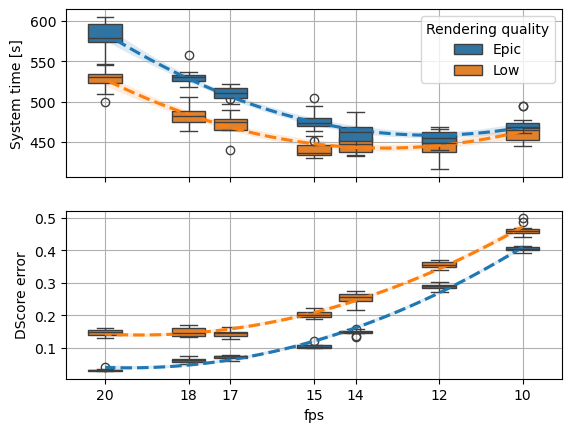

In [4]:
def new_boxplot(agg, ax, col='driving_score_error'):

    epicq = agg.xs("True", level='highquality',
                   drop_level=False).reset_index()
    lowq = agg.xs("False", level='highquality',
                  drop_level=False).reset_index()

    ax = sns.boxplot(lowq, x='fps', y=col, hue='highquality', ax=ax, native_scale=True, hue_order=["True", "False"]
                     )

    ax = sns.boxplot(epicq, x='fps', y=col,
                     hue='highquality', ax=ax,  native_scale=True, hue_order=["True", "False"])

    ax = sns.regplot(epicq, x='fps', y=col, ax=ax,
                     order=2, scatter=False, line_kws=dict(linestyle='dashed'),)

    ax = sns.regplot(lowq, x='fps', y=col, ax=ax,  order=2,
                     scatter=False, line_kws=dict(linestyle='dashed'),)


def make_boxplots(df):

    agg = df[['driving_score_error', 'duration_system']].groupby(
        ['fps', 'highquality', "rep"]).mean()

    vals = set(agg.reset_index()['fps'].values)

    f, axes = plt.subplots(nrows=2, sharex=True,)
    axes[0].invert_xaxis()

    axes[0].set_ylabel(f"System time [s]")
    new_boxplot(agg, ax=axes[0], col='duration_system')
    axes[0].grid()
    axes[0].set_xticks(list(vals))
    axes[0].set_ylabel(f"System time [s]")

    new_boxplot(agg, ax=axes[1], col='driving_score_error')
    axes[1].get_legend().remove()
    axes[1].grid()
    axes[1].set_ylabel(f"DScore error")

    handles, _ = axes[0].get_legend_handles_labels()

    axes[0].legend(handles=handles, labels=["Epic", "Low"],
                   title="Rendering quality")

    # f.savefig('plot_rq12.pdf', bbox_inches='tight')


make_boxplots(df)

## Are low fid benefictial for robust scenarios?


### Label fidelity robustness

Based on averaged DScore error


In [5]:
# average the data across repetitions
data = df.select_dtypes('number').groupby(
    ['fps', "highquality", 'route_index']).mean()


safe_threshold = 0.01
risky_threshold = 0.25

data.loc[:, 'label'] = np.select(
    [data['driving_score_error'] < safe_threshold,
     data['driving_score_error'].between(safe_threshold, risky_threshold),
     data['driving_score_error'] > risky_threshold,
     ],
    ['safe', 'moderate', 'risky',],
)

### Crease mask of safe scenarios


In [6]:
safety_mask = data['label'] == 'safe'
# safety_mask

### Plot


/tmp/ipykernel_76718/1679077455.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  draw_subplot(axes[1], df[safety_mask], "Only fid-safe")


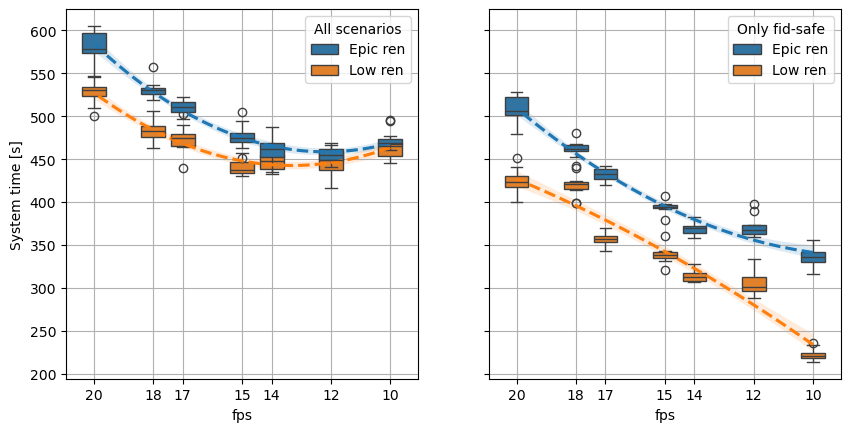

In [7]:
f, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
f.set_figwidth(10)

axes[0].invert_xaxis()

axes[0].set_ylabel(f"System time [s]")
vals = set(df.reset_index()['fps'].values)
axes[0].set_xticks(list(vals))


def draw_subplot(ax, df, title):
    ax.grid()
    agg = df.select_dtypes('number').groupby(
        ['fps', 'highquality', "rep"]).mean()
    new_boxplot(agg, ax, col='duration_system')

    ax.set_ylabel(f"System time [s]")
    handles, _ = ax.get_legend_handles_labels()

    ax.legend(handles=handles, labels=["Epic ren", "Low ren"],
              title=title)


draw_subplot(axes[0], df, "All scenarios")
draw_subplot(axes[1], df[safety_mask], "Only fid-safe")

### Conclusion

For safe scenarios low fidelity is showing a REAL benefit/potential


## Robustness distribution


In [12]:
def draw_dist(data):

    data = data.reset_index()
    data['fps'] = data['fps'].astype(str)

    fig, (ax1,  ax2) = plt.subplots(1, 2, sharex=True)
    fig.set_figwidth(15)

    sns.histplot(
        data, x="fps", hue='label', hue_order=['risky', 'moderate', 'safe'], multiple="stack",  shrink=.8, ax=ax1
    )

    sns.stripplot(data, x='fps', y='driving_score_error', hue='label', hue_order=['risky', 'moderate', 'safe'],
                  ax=ax2)
    ax2.set_ylabel("DScore error")

### All scenarios


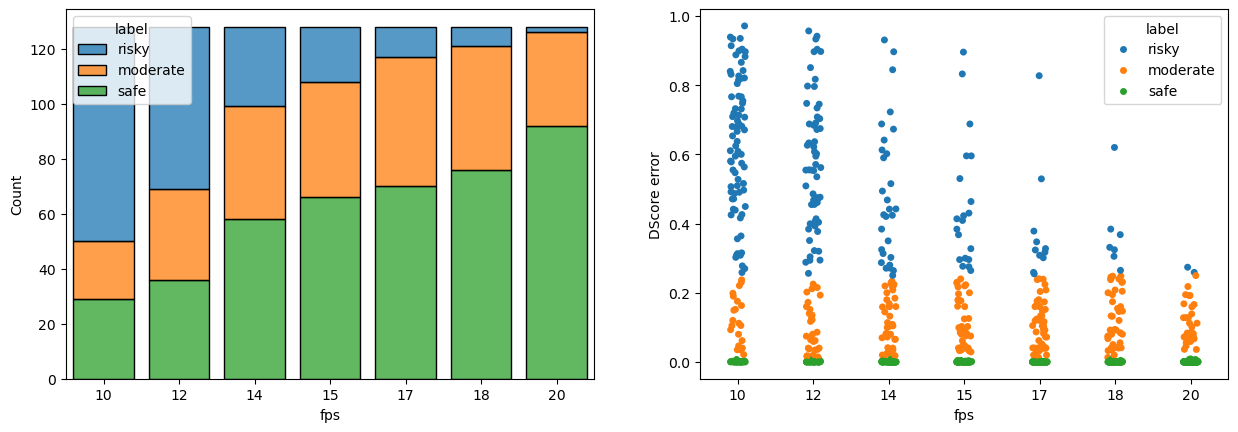

In [16]:
epic = data.xs("True", level='highquality')
draw_dist(epic)

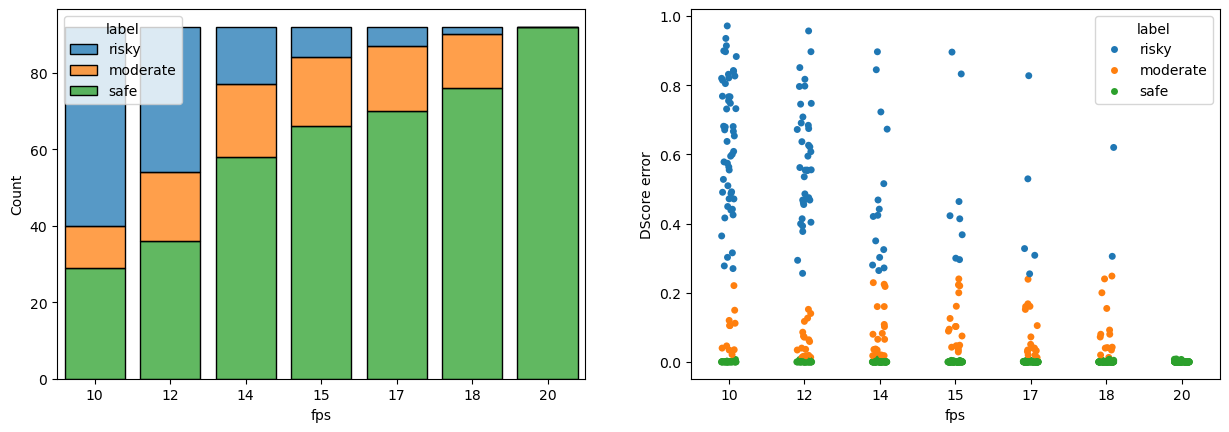

In [17]:
highfid = epic.xs(20, level='fps')
safe_mask = highfid['label'] == 'safe'
# safe_mask
nonflakey = epic.where(safe_mask).dropna()

draw_dist(nonflakey)